In [101]:
import numpy as np
import torch
from torch import nn
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
def U(X, means, sigmas, p):
    exp = torch.exp(-torch.cat([torch.pow(X - means[i], 2) / (2 * sigmas[i] ** 2) for i in range(len(means))], dim=1))
    coefs = p / (np.sqrt(2 * np.pi) * sigmas)
    return -torch.log(torch.matmul(exp, coefs))

In [84]:
p = torch.tensor([0.5, 0.5])
sigmas = torch.tensor([1., 1.])
means = torch.tensor([2, -2])

In [85]:
def mixture_sampler(means=[0], sigmas=[1], p=[1], size=1):
    sample = []
    for _ in range(size):
        i = np.random.choice(np.arange(len(p)), p=p)
        sample.append(np.random.normal(loc=means[i], scale=sigmas[i], size=1))
    return np.vstack(sample)

In [86]:
X = torch.tensor(mixture_sampler(means, sigmas, p.numpy(), 10000), dtype=torch.float32, requires_grad=True)
f_X = torch.pow(X, 3).squeeze()

In [87]:
def b(X, U_deriv, deg):
    poly1 = torch.vander(X.squeeze(), N=deg + 1)
    poly1 = poly1[:, :-1]
    second_term = torch.mul(poly1, U_deriv.reshape(-1, 1))
    first_term = torch.vander(X.squeeze(), N=deg)
    coef = torch.arange(deg, 0, -1, dtype=torch.float32).reshape(1, -1)
    first_term = torch.mul(first_term, coef)
    return first_term - second_term

In [89]:
def Learn(X, means, sigmas, p, deg=5):
  U_X = U(X, means, sigmas, p)
  X.grad = None
  U_X.sum().backward(retain_graph=True)
  U_X_prime = X.grad.squeeze()

  beshki = b(X, U_X_prime, deg) # deg = 5

  b_norm = beshki - torch.mean(beshki, dim=0)
  f = X**3
  f_norm = f - torch.mean(f)
  V = b_norm[:, :, None] @ b_norm[:, None, :]
  V /= V.shape[0] - 1
  V = V.sum(dim=0)
  b_norm *= f_norm.reshape(-1, 1)
  C = b_norm.T
  C /= C.shape[1] - 1
  C = C.sum(dim=1).reshape(-1, 1)
  V_inverse = torch.inverse(V)
  theta = V_inverse @ C

  g = beshki @ theta
  g_norm = g - torch.mean(g)
  l = f_norm - g_norm
  vr = (f - g).mean().item()

  return theta, l, vr

In [90]:
theta, l, _ = Learn(X, means, sigmas, p)

In [91]:
print(torch.sum(l**2) / (l.shape[0] - 1))

tensor(220.5618, grad_fn=<DivBackward0>)


In [92]:
def Pi_f(means, sigmas, p):
    return (p * (torch.pow(means, 3) + 3 * means * torch.pow(sigmas, 2))).sum().item()

In [11]:
x = torch.tensor(np.linspace(-5, 5, 10000).reshape(-1, 1), dtype=torch.float32, requires_grad=True)

U_X = U(x, means, sigmas, p)
x.grad = None
U_X.sum().backward(retain_graph=True)
U_X_prime = x.grad.squeeze()
beshki = b(x, U_X_prime, 5) # deg = 5

g_x = beshki @ theta
g_x_numpy = g_x.detach().numpy()
x_numpy = x.detach().numpy()
pi_f = Pi_f(means, sigmas, p)

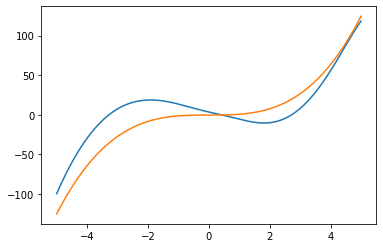

In [12]:
plt.plot(x_numpy, g_x_numpy)
f_numpy = x_numpy ** 3
plt.plot(x_numpy, f_numpy - pi_f);

In [13]:
estimates = []
vr_estimates = []
np.random.seed(42)

for i in range(100):
  p = torch.tensor([0.5, 0.5])
  sigmas = torch.tensor([2., 1.])
  means = torch.tensor([-1., 2.])
  X = torch.tensor(mixture_sampler(means, sigmas, p, 10000), dtype=torch.float32, requires_grad=True)

  U_X = U(X, means, sigmas, p)
  X.grad = None
  U_X.sum().backward(retain_graph=True)
  U_X_prime = X.grad.squeeze()

  f_X = torch.pow(X, 3).squeeze()
  estimates.append(f_X.mean().item())

  beshki = b(X, U_X_prime, 5) # deg = 5
  g = beshki @ theta
  vr = (f_X - g).mean().item()

  vr_estimates.append(vr)

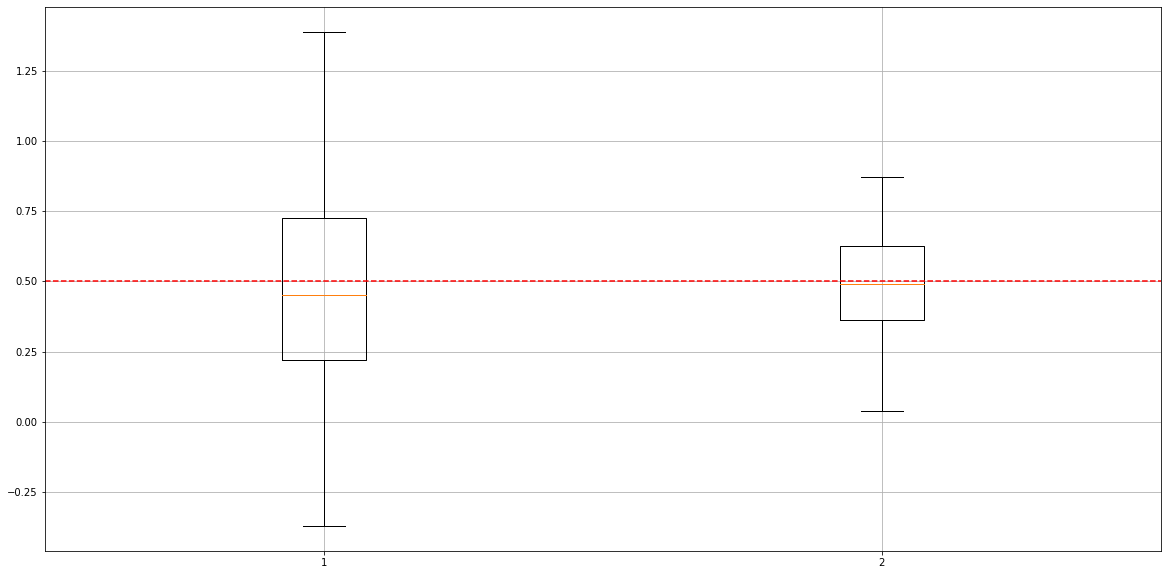

In [14]:
plt.figure(figsize=(20, 10))
plt.boxplot([estimates, vr_estimates])
plt.axhline(y=pi_f, color='r', linestyle='--')
plt.grid(True)

In [93]:
sample_theta = []
for _ in range(5):
    sample_theta.append(np.random.normal(loc=0.5, scale=2.0, size=1))
rand_theta = torch.tensor(np.vstack(sample_theta), dtype=torch.float32)
rand_theta -= torch.ones(rand_theta.shape[0]).reshape(-1, 1)
print(rand_theta)

tensor([[-0.4934],
        [ 0.1340],
        [ 1.7951],
        [ 0.5538],
        [-0.6356]])


In [94]:
estimates = []
np.random.seed(42)

for i in range(100):
  p = torch.tensor([0.5, 0.5])
  sigmas = torch.tensor([2., 1.])
  means = torch.tensor([-1., 2.])
  X = torch.tensor(mixture_sampler(means, sigmas, p, 10000), dtype=torch.float32, requires_grad=True)

  U_X = U(X, means, sigmas, p)
  X.grad = None
  U_X.sum().backward(retain_graph=True)
  U_X_prime = X.grad.squeeze()

  beshki = b(X, U_X_prime, 5)
  g = beshki @ rand_theta
  estimates.append(g.mean().item())

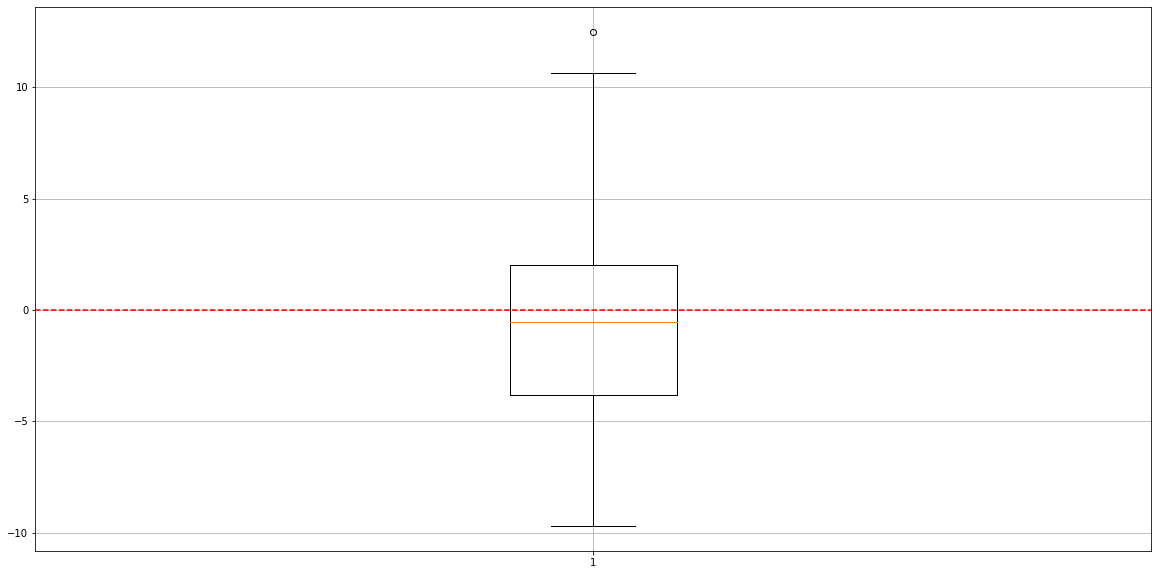

In [95]:
plt.figure(figsize=(20, 10))
plt.boxplot([estimates])
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)

In [110]:
results = []
pi_fs = []
a = [1, 2, 3, 4]
fix_deg = 5

for mean in a:
  estimates = []
  vr_estimates = []
  p = torch.tensor([0.5, 0.5])
  sigmas = torch.tensor([1., 1.])
  means = torch.tensor([mean, -mean])
  X = torch.tensor(mixture_sampler(means, sigmas, p.numpy(), 1000), dtype=torch.float32, requires_grad=True)
  f_X = torch.pow(X, 3).squeeze()
  theta, l, _ = Learn(X, means, sigmas, p, fix_deg)
  pi_fs.append(Pi_f(means, sigmas, p))
  for i in tqdm_notebook(range(100)):
    X = torch.tensor(mixture_sampler(means, sigmas, p.numpy(), 1000), dtype=torch.float32, requires_grad=True)

    U_X = U(X, means, sigmas, p)
    X.grad = None
    U_X.sum().backward(retain_graph=True)
    U_X_prime = X.grad.squeeze()

    f_X = torch.pow(X, 3).squeeze()
    estimates.append(f_X.mean().item())

    beshki = b(X, U_X_prime, fix_deg) # deg = 5
    g = beshki @ theta
    vr = (f_X - g).mean().item()

    vr_estimates.append(vr)
  print(np.var(estimates))
  print(np.var(vr_estimates))
  results.append(vr_estimates)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0.07403937761384966
0.030136169671033657



0.4802396061605582
0.21032654309499524



2.2172379981365196
1.2337156492976409



7.941396904803202
5.2812169997698835


In [ ]:
samples = np.load("sample3.npy")
estimates = []
vr_estimates = []
p = torch.tensor([0.5, 0.5])
sigmas = torch.tensor([1., 1.])
means = torch.tensor([3, -3])
X = torch.tensor(mixture_sampler(means, sigmas, p.numpy(), 1000), dtype=torch.float32, requires_grad=True)
f_X = torch.pow(X, 3).squeeze()
theta, l, _ = Learn(X, means, sigmas, p, fix_deg)
pi_fs.append(Pi_f(means, sigmas, p))

for i in tqdm_notebook(range(100)):
  X = torch.tensor(samples[i], requires_grad=True)

  U_X = U(X, means, sigmas, p)
  X.grad = None
  U_X.sum().backward(retain_graph=True)
  U_X_prime = X.grad.squeeze()

  f_X = torch.pow(X, 3).squeeze()
  estimates.append(f_X.mean().item())

  beshki = b(X, U_X_prime, fix_deg) # deg = 5
  g = beshki @ theta
  vr = (f_X - g).mean().item()

  vr_estimates.append(vr)

print(np.var(estimates))
print(np.var(vr_estimates))
results.append(vr_estimates)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



2.271346585908948
1.2139774943268828


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


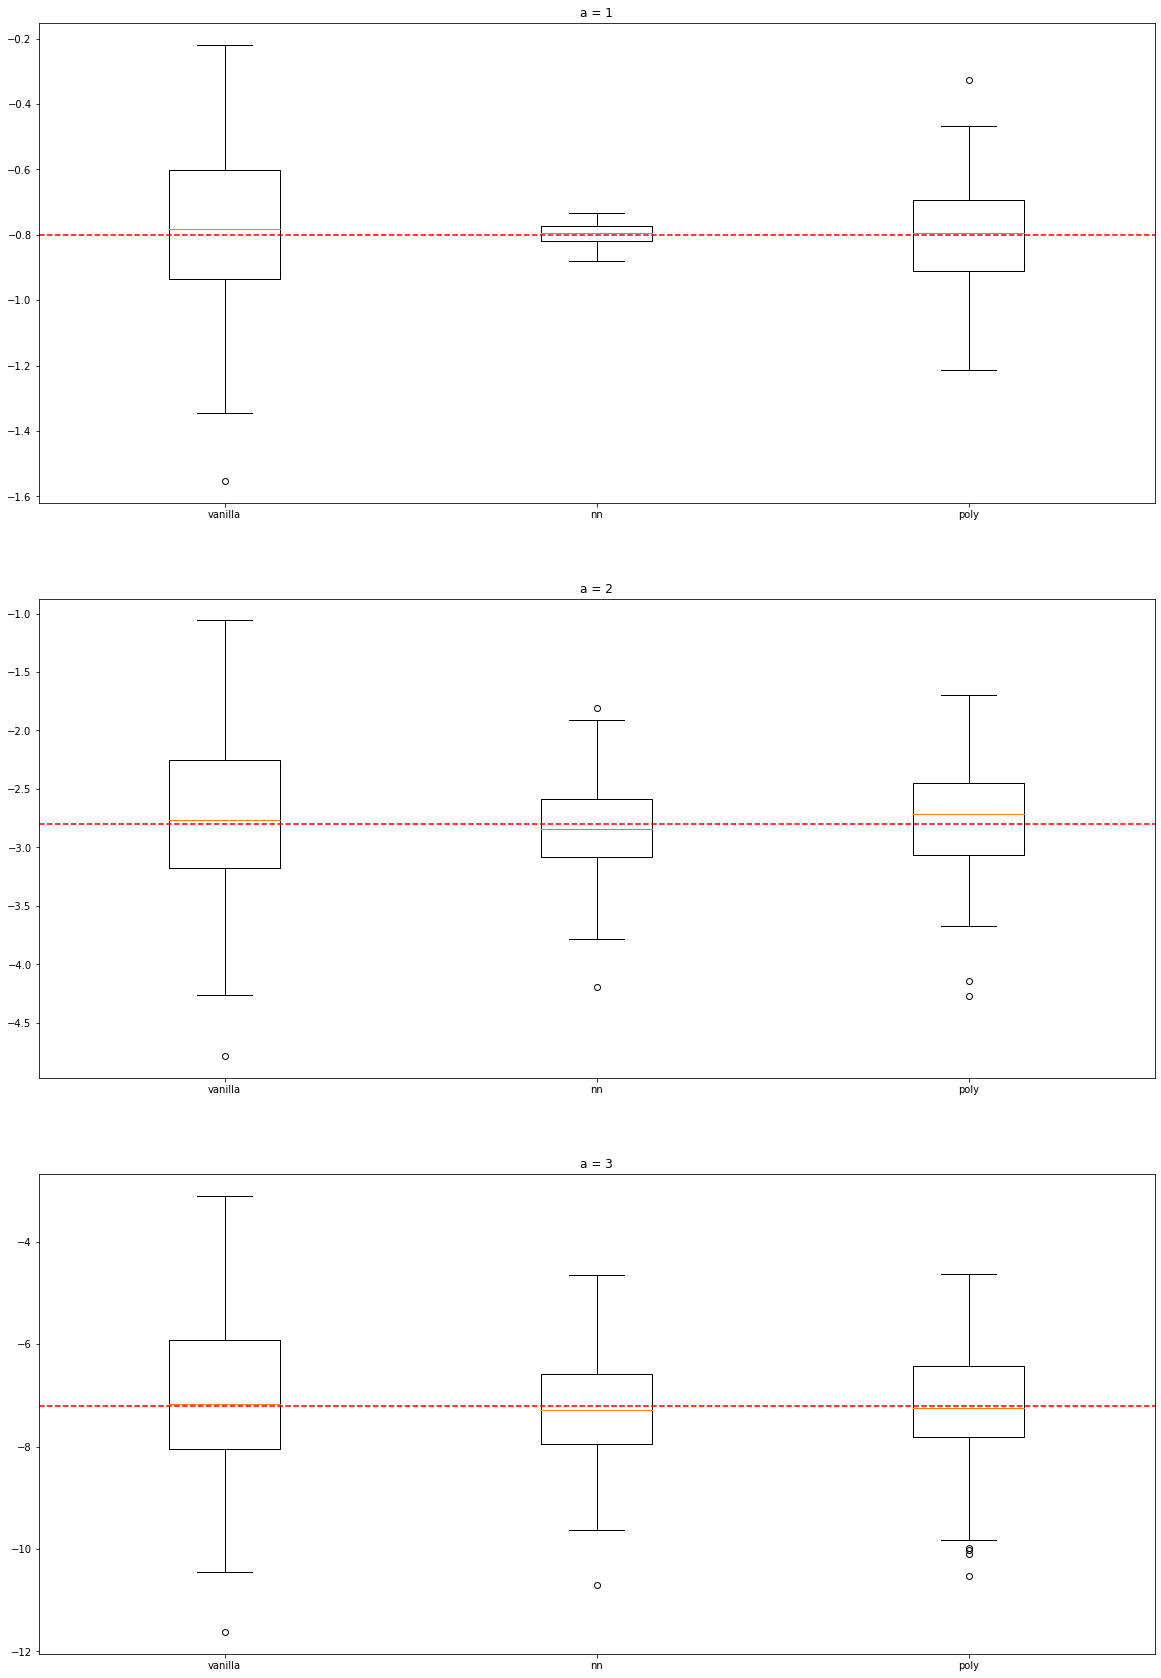

In [74]:
nn_vr = []
vanilla = []
nn_vr.append(np.load("nn_vr1.npy"))
vanilla.append(np.load("vanilla1.npy"))
nn_vr.append(np.load("nn_vr2.npy"))
vanilla.append(np.load("vanilla2.npy"))
nn_vr.append(np.load("nn_vr3.npy"))
vanilla.append(np.load("vanilla3.npy"))

fig, axs = plt.subplots(3, 1, figsize=(20, 30))
for i, mean in enumerate(a):
  axs[i].boxplot([vanilla[i], nn_vr[i], results[i]], labels=["vanilla", "nn", "poly"])
  axs[i].axhline(y=pi_fs[i], color='r', linestyle='--')
  axs[i].set_title("a = {:d}".format(mean))